
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/miokobayashii/summerschool2022/blob/main/day04/Practice14_CGAN_handwrittenDigits.ipynb)

# Conditional GAN

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape, Dropout, LeakyReLU)
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.losses import BinaryCrossentropy
from keras.models import Model, Sequential, load_model
from keras.optimizers import adam_v2


In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Generator

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128 * 4 * 4, input_dim=z_dim))
    model.add(Reshape((4, 4, 128)))

    # Transposed convolution layer
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', output_padding=0))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

    model.compile()

    return model

In [ ]:
generator = build_generator(z_dim)
generator.summary()

from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='model.png', show_shapes=True)

In [ ]:
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)

    # Element-wise product of the vectors z and the label embeddings
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # Generate image for the given label
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

In [ ]:
cgan_generator = build_cgan_generator(z_dim)
cgan_generator.summary()

from keras.utils.vis_utils import plot_model
plot_model(cgan_generator, to_file='model.png', show_shapes=True)

## Discriminator

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))

    # Convolutional layer, from 14x14x64 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.4))

   ## 
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.2))
   # model.add(Dropout(0.4))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator.summary()

from keras.utils.vis_utils import plot_model
plot_model(discriminator, to_file='model.png', show_shapes=True)

In [ ]:
def build_cgan_discriminator(img_shape):

    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)

    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate images with their label embeddings
    #concatenated = Concatenate(axis=-1)([img, label_embedding])
    multiplied = Multiply()([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(multiplied)

    return Model([img, label], classification)

In [ ]:
cgan_discriminator = build_cgan_discriminator(img_shape)
cgan_discriminator.summary()

from keras.utils.vis_utils import plot_model
plot_model(cgan_discriminator, to_file='model.png', show_shapes=True)

## Build the Model

In [ ]:
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(1, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

In [ ]:
# Build and compile the Discriminator

discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer= adam_v2.Adam(learning_rate=0.001, beta_1=0.5),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)
generator.compile()

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.001, beta_1=0.5), metrics=['accuracy'])

In [ ]:
# If you want to use saved discriminator and generator models after you saved models, uncomment below and run instead of the program above.

#discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan_discriminator.h5')
#generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan_generator.h5')

#discriminator.trainable = False
#cgan = build_cgan(generator, discriminator)
#cgan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0001, beta_1=0.5), metrics=['accuracy'])

## Training

In [ ]:
accuracies = []
losses = []


def train(batch_size, sample_interval, n_epochs = 5):

    # Load the MNIST dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    bat_per_epo = int((X_train.shape[0]) / batch_size)
    half_batch = int(batch_size / 2)

    # Labels for real images: all ones
    real = np.ones((half_batch, 1))
    real_for_generator = np.ones((batch_size, 1))
    # Labels for fake images: all zeros
    fake = np.zeros((half_batch, 1))

    for i in range(n_epochs):
      for j in range(bat_per_epo):
    #for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------
        # for test
        #np.random.seed(314) 
        
        # Get a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (half_batch, z_dim))
        gen_imgs = generator.predict([z, labels], verbose=0)

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # Get a batch of random labels
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the Generator
        g_loss = cgan.train_on_batch([z, labels], real_for_generator )

        if (i*10 +  j + 1)  % sample_interval == 0:

            # Output training progress
            print("Epoch:%d %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (i + 1, j+1, bat_per_epo, d_loss[0], 100 * d_loss[1], g_loss[0]))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    labels = np.arange(0, 10).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels], verbose=0)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(8, 3),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1
    plt.show()

# Train the Model and Inspect Training Progress

In [ ]:
# Set hyperparameters
epochs = 50
batch_size = 256
sample_interval = 100

# Train the CGAN for the specified number of iterations
train(batch_size, sample_interval,epochs)

# If you want to save a generator and discriminator, uncommet the lines below.

generator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan_generator_2.h5', include_optimizer=True)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(learning_rate=0.001, beta_1=0.5),metrics=['accuracy'])
discriminator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan_discriminator_2.h5', include_optimizer=True)
#cgan.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan.h5', include_optimizer=True)

Output hidden; open in https://colab.research.google.com to view.

# Output from a Trained CGAN Model

In [ ]:
from keras.models import load_model
generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day04/cgan_generator_2.h5')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2/2 [==============================] - 0s 38ms/step


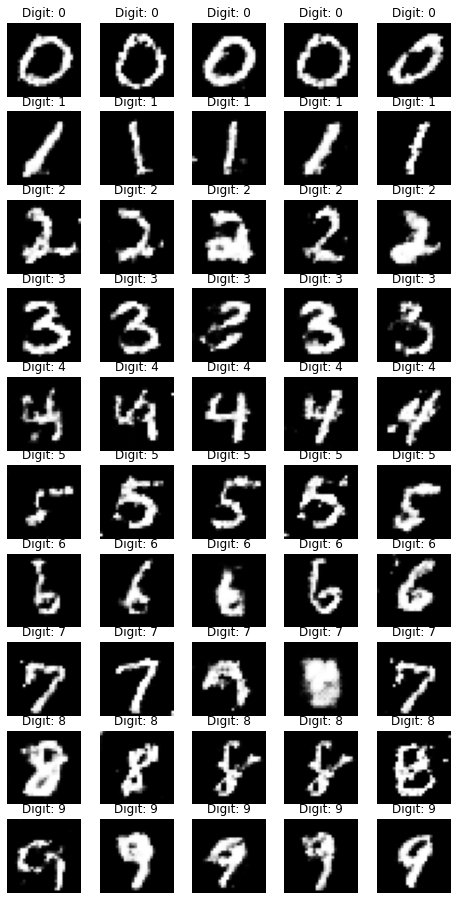

In [ ]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(image_grid_columns)] for i in range(image_grid_rows)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(8, 16),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images 
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

----